# Импортирование библиотек

In [1]:
import pandas as pd

In [2]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt

In [4]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV

In [5]:
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [6]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    RocCurveDisplay,
    PrecisionRecallDisplay,
    brier_score_loss,
    confusion_matrix,
)

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    RandomForestClassifier,
    StackingClassifier,
)
from sklearn.inspection import permutation_importance

# Вспомогательные функции

In [8]:
def compute_metrics(y_true, y_pred, y_proba=None) -> dict:
    m = {
        "accuracy": float(accuracy_score(y_true, y_pred)),
        "f1": float(f1_score(y_true, y_pred)),
    }
    if y_proba is not None:
        try:
            m["roc_auc"] = float(roc_auc_score(y_true, y_proba))
        except Exception:
            m["roc_auc"] = None
    else:
        m["roc_auc"] = None
    return m

def evaluate_on_test(model, X_test, y_test, label: str) -> dict:
    pred = model.predict(X_test)
    proba = None
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X_test)[:, 1]
    metrics = compute_metrics(y_test, pred, proba)
    metrics["model"] = label
    return metrics
def run_search(label: str, estimator, param_grid:dict):
    search = GridSearchCV(
        estimator, param_grid,
        scoring="roc_auc",
        cv=cv,
        n_jobs=-1,
        refit=True,
        return_train_score=True
    )
    search.fit(X_train, y_train)
    best = search.best_estimator_
    best_models[label] = best
    search_summaries[label] = {
        "best_params": search.best_params_,
        "best_cv_roc_auc": float(search.best_score_),
    }
    results.append(evaluate_on_test(best, X_test, y_test, label))

# Загрузка и первичный анализ датасета

In [9]:
RANDOM_STATE=42
np.random.seed(RANDOM_STATE)

In [10]:
df = pd.read_csv("S06-hw-dataset-02.csv")

In [11]:
df

,id,f01,f02,f03,f04,f05,f06,f07,f08,f09,...,f29,f30,f31,f32,f33,f34,f35,x_int_1,x_int_2,target
0,1,-0.149235,-2.826966,-0.522901,-4.198449,1.364943,0.815043,-1.195518,-1.932232,2.396353,...,-0.159323,0.448015,0.572745,0.149916,0.878392,-0.679733,1.412751,0.421883,9.217167,1
1,2,-1.966180,-4.877542,0.268367,-9.607791,0.097149,1.347185,-3.872575,-0.395117,1.710068,...,-0.389212,1.383794,0.169876,0.043969,-0.963545,1.006643,-2.488690,9.590124,24.772826,0
2,3,-0.555964,-0.999920,0.209673,-14.119498,-1.808950,-0.006222,-4.651108,0.911944,-0.289037,...,-1.383970,3.044321,-0.182864,1.425649,-8.418598,-4.629754,-0.439798,0.555919,41.800517,0
3,4,-2.049199,-5.600713,-1.664677,-6.263893,-5.224455,0.848351,1.407210,-0.542080,0.119102,...,-2.713080,2.762637,-0.520796,-0.142455,1.668338,2.292810,-10.744916,11.476977,65.315860,0
4,5,-0.220556,4.889479,-2.235840,6.450046,0.774389,-2.382625,2.584816,4.211856,-0.317889,...,-1.302872,2.478862,1.528610,1.098131,3.547087,2.517757,-9.364106,-1.078404,93.017870,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17995,17996,-1.920557,-1.422719,-1.031828,2.094948,-0.067437,-0.469716,1.427896,1.429689,-1.938858,...,-0.768946,-2.549755,2.079189,0.206839,4.900957,1.888136,-2.584146,2.732414,4.528493,1
17996,17997,-1.914101,-2.124938,1.216011,-9.308270,-1.024236,-0.301606,-5.320400,-1.922336,1.645415,...,0.821849,0.794824,-0.043603,0.622274,-5.862803,-0.918845,-1.203823,4.067347,105.359894,0
17997,17998,-1.846604,7.583639,-1.107318,3.319625,3.065063,0.791241,-2.855133,0.717440,1.554351,...,0.458406,-3.135470,0.651596,-1.625199,-2.758888,1.770906,-0.067665,-14.003977,12.202548,0
17998,17999,1.742157,1.722399,-0.849028,5.751745,3.271935,-1.666774,4.501935,1.714487,0.528713,...,-1.607060,0.248146,-0.448578,0.681331,7.190156,-1.025952,3.629549,3.000691,28.088015,0


In [12]:
df.head()

,id,f01,f02,f03,f04,f05,f06,f07,f08,f09,...,f29,f30,f31,f32,f33,f34,f35,x_int_1,x_int_2,target
0,1,-0.149235,-2.826966,-0.522901,-4.198449,1.364943,0.815043,-1.195518,-1.932232,2.396353,...,-0.159323,0.448015,0.572745,0.149916,0.878392,-0.679733,1.412751,0.421883,9.217167,1
1,2,-1.966180,-4.877542,0.268367,-9.607791,0.097149,1.347185,-3.872575,-0.395117,1.710068,...,-0.389212,1.383794,0.169876,0.043969,-0.963545,1.006643,-2.488690,9.590124,24.772826,0
2,3,-0.555964,-0.999920,0.209673,-14.119498,-1.808950,-0.006222,-4.651108,0.911944,-0.289037,...,-1.383970,3.044321,-0.182864,1.425649,-8.418598,-4.629754,-0.439798,0.555919,41.800517,0
3,4,-2.049199,-5.600713,-1.664677,-6.263893,-5.224455,0.848351,1.407210,-0.542080,0.119102,...,-2.713080,2.762637,-0.520796,-0.142455,1.668338,2.292810,-10.744916,11.476977,65.315860,0
4,5,-0.220556,4.889479,-2.235840,6.450046,0.774389,-2.382625,2.584816,4.211856,-0.317889,...,-1.302872,2.478862,1.528610,1.098131,3.547087,2.517757,-9.364106,-1.078404,93.017870,0


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18000 entries, 0 to 17999
Data columns (total 39 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       18000 non-null  int64  
 1   f01      18000 non-null  float64
 2   f02      18000 non-null  float64
 3   f03      18000 non-null  float64
 4   f04      18000 non-null  float64
 5   f05      18000 non-null  float64
 6   f06      18000 non-null  float64
 7   f07      18000 non-null  float64
 8   f08      18000 non-null  float64
 9   f09      18000 non-null  float64
 10  f10      18000 non-null  float64
 11  f11      18000 non-null  float64
 12  f12      18000 non-null  float64
 13  f13      18000 non-null  float64
 14  f14      18000 non-null  float64
 15  f15      18000 non-null  float64
 16  f16      18000 non-null  float64
 17  f17      18000 non-null  float64
 18  f18      18000 non-null  float64
 19  f19      18000 non-null  float64
 20  f20      18000 non-null  float64
 21  f21      180

In [14]:
df.describe()

,id,f01,f02,f03,f04,f05,f06,f07,f08,f09,...,f29,f30,f31,f32,f33,f34,f35,x_int_1,x_int_2,target
count,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,...,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,1.800000e+04,18000.000000
mean,9000.500000,-0.418555,0.614251,0.004559,0.059000,0.405086,0.012123,-0.283473,-0.266880,0.255107,...,-0.139825,0.108568,0.007238,0.000904,-0.716862,-0.274520,0.344991,1.517339,2.576221e+01,0.262611
std,5196.296758,2.178005,3.926778,1.000134,5.713672,2.497581,0.987226,2.193891,2.081431,2.225776,...,2.148834,2.234315,0.997861,1.002115,3.913704,2.482890,4.927315,10.630850,5.423748e+01,0.440065
min,1.000000,-10.014698,-15.510323,-4.031762,-23.663256,-12.289308,-3.741536,-9.591425,-8.293319,-13.655742,...,-8.171469,-9.214171,-3.937091,-3.963063,-19.389908,-10.031559,-20.768452,-107.788145,1.895059e-07,0.000000
25%,4500.750000,-1.866134,-2.048192,-0.673127,-3.544964,-1.153000,-0.653090,-1.743214,-1.688121,-1.177480,...,-1.589638,-1.369266,-0.663023,-0.684164,-3.286842,-1.897893,-2.752685,-2.018750,1.226029e+00,0.000000
50%,9000.500000,-0.465100,0.600291,0.003581,0.072826,0.485625,0.018765,-0.251263,-0.302463,0.350739,...,-0.204785,0.158715,0.001912,-0.003157,-0.618472,-0.339901,0.573153,0.318011,6.581865e+00,0.000000
75%,13500.250000,0.966393,3.229850,0.671390,3.689490,2.075739,0.689304,1.195481,1.109589,1.764113,...,1.254595,1.600671,0.677296,0.676558,1.948803,1.314163,3.649794,4.212111,2.576847e+01,1.000000
max,18000.000000,9.589975,15.417329,3.817025,26.815691,10.665184,3.528280,7.794627,8.892834,8.699629,...,9.290667,8.794320,4.341030,3.781380,14.065595,10.639974,20.226291,94.891804,1.103449e+03,1.000000


In [15]:
df['target'].value_counts(normalize=True) # анализ распределения таргета

target
0    0.737389
1    0.262611
Name: proportion, dtype: float64

In [16]:
# Пропуски
for column in df.columns:
    if df[column].isna().mean()*100 != 0:
        print(f"Доля пропусков в колонке {column}: {df[column].isna().mean()*100:.2f}% ")
        print(df[df[column].isna()])
# В датасете не найдены пропуски и дубликаты

# Дубликаты
print("Количество дубликатов:", df.duplicated().to_list().count(True)) if df.duplicated().to_list().count(True) != 0 else print("")

In [17]:
X = df.drop(["target","id"],axis=1)
y = df["target"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=RANDOM_STATE,
    stratify=y
)

#### Фиксированный сид и стратификация важны, т. к. ...

# Baseline'ы

#### Штирлиц прописал кросс-валидацию на train: train уехал

In [18]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
results = []
best_models = {}  # label -> fitted best estimator
search_summaries = {}  # label -> краткая инфа о подборе

In [19]:
dummy = DummyClassifier(strategy="most_frequent", random_state=RANDOM_STATE)

In [20]:
dummy.fit(X_train, y_train)

,"strategy strategy: {""most_frequent"", ""prior"", ""stratified"", ""uniform"", ""constant""}, default=""prior""Strategy to use to generate predictions.* ""most_frequent"": the `predict` method always returns the most frequent class label in the observed `y` argument passed to `fit`. The `predict_proba` method returns the matching one-hot encoded vector.* ""prior"": the `predict` method always returns the most frequent class label in the observed `y` argument passed to `fit` (like ""most_frequent""). ``predict_proba`` always returns the empirical class distribution of `y` also known as the empirical class prior distribution.* ""stratified"": the `predict_proba` method randomly samples one-hot vectors from a multinomial distribution parametrized by the empirical class prior probabilities. The `predict` method returns the class label which got probability one in the one-hot vector of `predict_proba`. Each sampled row of both methods is therefore independent and identically distributed.* ""uniform"": generates predictions uniformly at random from the list of unique classes observed in `y`, i.e. each class has equal probability.* ""constant"": always predicts a constant label that is provided by the user. This is useful for metrics that evaluate a non-majority class. .. versionchanged:: 0.24 The default value of `strategy` has changed to ""prior"" in version 0.24.",'most_frequent'
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness to generate the predictions when``strategy='stratified'`` or ``strategy='uniform'``.Pass an int for reproducible output across multiple function calls.See :term:`Glossary `.",42
,"constant constant: int or str or array-like of shape (n_outputs,), default=NoneThe explicit constant as predicted by the ""constant"" strategy. Thisparameter is useful only for the ""constant"" strategy.",None


In [21]:
y_test_pred_dummy = dummy.predict(X_test)
y_test_proba_dummy = dummy.predict_proba(X_test)[:, 1]

Оценка бейзлайна по метрикам
Accuracy : 0.7373333333333333
F1 : 0.0
ROC-AUC  : 0.5
[[3318    0]
 [1182    0]]


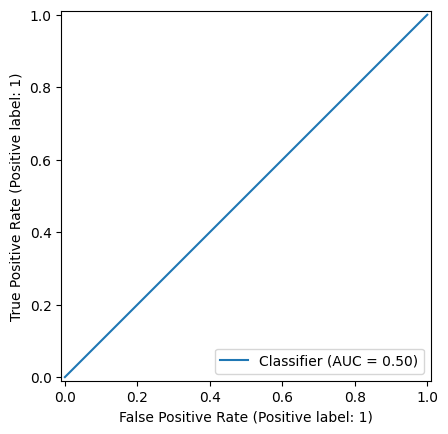

In [22]:
# OLD
print("Оценка бейзлайна по метрикам")
bsl_ac = accuracy_score(y_test, y_test_pred_dummy)
bsl_roc = roc_auc_score(y_test, y_test_proba_dummy)
bsl_f1 = f1_score(y_test, y_test_pred_dummy)
print("Accuracy :", bsl_ac)
print("F1 :", bsl_f1)
try:
    print("ROC-AUC  :", bsl_roc)
except ValueError as e:
    print("Не удалось посчитать ROC-AUC для бейзлайна:", e)
print(confusion_matrix(y_test, y_test_pred_dummy))
plot = RocCurveDisplay.from_predictions(
    y_test,
    y_test_proba_dummy,
) # какая красота)))
# NEW
results.append(evaluate_on_test(dummy, X_test, y_test, "Dummy(most_frequent)"))
best_models["Dummy(most_frequent)"] = dummy

In [23]:
logreg = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=4000, random_state=RANDOM_STATE))
])

In [24]:
logreg_grid = {
    "logreg__C": [0.1, 1.0, 10.0],
    "logreg__l1_ratio": [0], # чтобы sklearn не ругался
    "logreg__solver": ["lbfgs"],
} # grid search

In [25]:
logreg_search = GridSearchCV(
    logreg, logreg_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    refit=True,
    return_train_score=True
)
logreg_search.fit(X_train, y_train)
print("Лучшие параметры:", logreg_search.best_params_)
print("Лучший ROC-AUC (по CV):", logreg_search.best_score_)

Лучшие параметры: {'logreg__C': 10.0, 'logreg__l1_ratio': 0, 'logreg__solver': 'lbfgs'}
Лучший ROC-AUC (по CV): 0.8031650183229327


Accuracy : 0.8162222222222222
F1 : 0.5717244950802693
ROC-AUC  : 0.8008935009673942
[[3121  197]
 [ 630  552]]


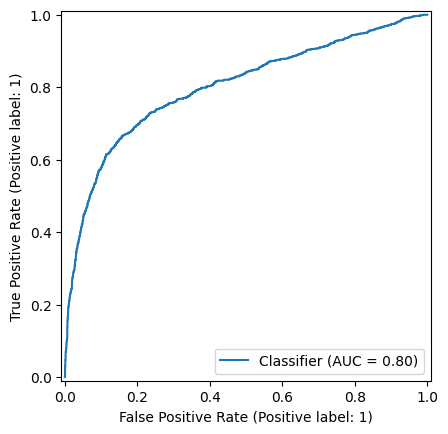

In [26]:
best_logreg = logreg_search.best_estimator_
best_models["LogReg(scaled)"] = best_logreg
search_summaries["LogReg(scaled)"] = {
    "best_params": logreg_search.best_params_,
    "best_cv_roc_auc": float(logreg_search.best_score_),
}
results.append(evaluate_on_test(best_logreg, X_test, y_test, "LogReg(scaled)"))

# OLD
y_test_pred_logreg = best_logreg.predict(X_test)
y_test_proba_logreg = best_logreg.predict_proba(X_test)[:, 1]
logreg_ac = accuracy_score(y_test, y_test_pred_logreg)
logreg_roc = roc_auc_score(y_test, y_test_proba_logreg)
logreg_f1 = f1_score(y_test, y_test_pred_logreg)
print("Accuracy :", logreg_ac)
print("F1 :", logreg_f1)
print("ROC-AUC  :", logreg_roc)
print(confusion_matrix(y_test, y_test_pred_logreg))
plot = RocCurveDisplay.from_predictions(
    y_test,
    y_test_proba_logreg,
) 

# Decision Tree

In [27]:
dt = DecisionTreeClassifier(random_state=RANDOM_STATE)
dt_grid = {
    "max_depth": [None, 3, 5, 8],
    "min_samples_leaf": [1, 5, 10, 20],
    "ccp_alpha": [0.0, 0.001, 0.005, 0.01],
}
dt_search = run_search("DecisionTree", dt, dt_grid)
search_summaries["DecisionTree"]

{'best_params': {'ccp_alpha': 0.0, 'max_depth': 8, 'min_samples_leaf': 20},
 'best_cv_roc_auc': 0.8266257396648813}

# Random Forest

In [28]:
rf = RandomForestClassifier(
    n_estimators=600,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    oob_score=False
)

rf_grid = {
    "max_depth": [None, 6, 10],
    "min_samples_leaf": [1, 5, 10],
    "max_features": ["sqrt", 0.5],
}

rf_search = run_search("RandomForest", rf, rf_grid)
search_summaries["RandomForest"]

{'best_params': {'max_depth': None,
  'max_features': 'sqrt',
  'min_samples_leaf': 1},
 'best_cv_roc_auc': 0.9276567544075277}

In [29]:
stump = DecisionTreeClassifier(max_depth=1, random_state=RANDOM_STATE)
ada = AdaBoostClassifier(
    estimator=stump,
    n_estimators=200,
    learning_rate=0.6,
    random_state=RANDOM_STATE
)
ada_grid = {
    "learning_rate": [0.03, 0.05, 0.1, 0.5, 0.6, 0.8],
    "n_estimators": [1, 10, 100, 200, 500, 1000]
}
ada_search = run_search("AdaBoost", ada, ada_grid)
search_summaries["AdaBoost"]

{'best_params': {'learning_rate': 0.6, 'n_estimators': 1000},
 'best_cv_roc_auc': 0.838021803333619}

# Stacking

In [30]:
estimators = [
    ("logreg", best_logreg),
    ("rf", best_models["RandomForest"]),
    ("ada", best_models["AdaBoost"]),
]
stack = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=4000, random_state=RANDOM_STATE),
    cv=5,
    n_jobs=-1,
    passthrough=False
)
stack.fit(X_train, y_train)
results.append(evaluate_on_test(stack, X_test, y_test, "Stacking"))

In [31]:
best_models["Stacking"] = stack
results

[{'accuracy': 0.7373333333333333,
  'f1': 0.0,
  'roc_auc': 0.5,
  'model': 'Dummy(most_frequent)'},
 {'accuracy': 0.8162222222222222,
  'f1': 0.5717244950802693,
  'roc_auc': 0.8008935009673942,
  'model': 'LogReg(scaled)'},
 {'accuracy': 0.8186666666666667,
  'f1': 0.6190476190476191,
  'roc_auc': 0.8317013337494608,
  'model': 'DecisionTree'},
 {'accuracy': 0.8935555555555555,
  'f1': 0.7627538385339276,
  'roc_auc': 0.9303352528228838,
  'model': 'RandomForest'},
 {'accuracy': 0.8355555555555556,
  'f1': 0.6092925026399155,
  'roc_auc': 0.8388961048233039,
  'model': 'AdaBoost'},
 {'accuracy': 0.9128888888888889,
  'f1': 0.8234234234234235,
  'roc_auc': 0.9329206226815941,
  'model': 'Stacking'}]

# Интерпретация

In [32]:
df = pd.DataFrame(results)
df_sorted = df.copy()
df_sorted["roc_auc_sort"] = df_sorted["roc_auc"].fillna(-1.0)
df_sorted = df_sorted.sort_values(["roc_auc_sort", "accuracy"], ascending=False).drop(columns=["roc_auc_sort"])
df_sorted

,accuracy,f1,roc_auc,model
5,0.912889,0.823423,0.932921,Stacking
3,0.893556,0.762754,0.930335,RandomForest
4,0.835556,0.609293,0.838896,AdaBoost
2,0.818667,0.619048,0.831701,DecisionTree
1,0.816222,0.571724,0.800894,LogReg(scaled)
0,0.737333,0.000000,0.500000,Dummy(most_frequent)


In [33]:
best_row = df_sorted.iloc[0]
best_label = best_row["model"]
best_model = best_models[best_label]

best_label, best_row.to_dict()

('Stacking',
 {'accuracy': 0.9128888888888889,
  'f1': 0.8234234234234235,
  'roc_auc': 0.9329206226815941,
  'model': 'Stacking'})

In [36]:
print(results[5])

{'accuracy': 0.9128888888888889, 'f1': 0.8234234234234235, 'roc_auc': 0.9329206226815941, 'model': 'Stacking'}


In [41]:
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]
confusion_matrix(y_test, y_pred)

array([[3194,  124],
       [ 268,  914]])

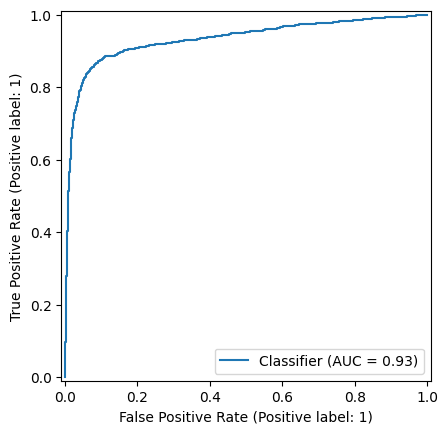

In [42]:
plot = RocCurveDisplay.from_predictions(
    y_test,
    y_proba,
)

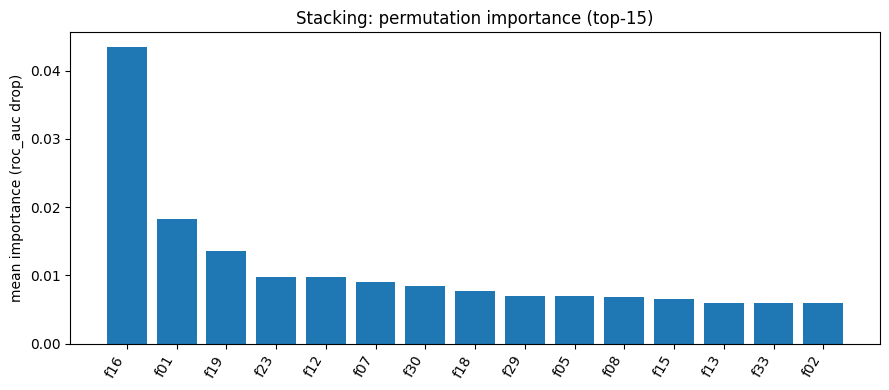

In [49]:
scoring = "roc_auc" if hasattr(best_model, "predict_proba") else "accuracy"
feature_names = [i for i in X.columns]
perm = permutation_importance(
    best_model,
    X_test,
    y_test,
    n_repeats=8,
    random_state=RANDOM_STATE,
    scoring=scoring
)

imp = perm.importances_mean
idx = np.argsort(imp)[::-1][:15]

plt.figure(figsize=(9, 4))
plt.bar(range(len(idx)), imp[idx])
plt.xticks(range(len(idx)), [feature_names[i] for i in idx], rotation=60, ha="right")
plt.ylabel(f"mean importance ({scoring} drop)")
plt.title(f"{best_label}: permutation importance (top-15)")
plt.tight_layout()
plt.show()

#### больше всего влияет....